In [6]:
import numpy as np
import pandas as pd
# %pip install osmnet
import pandana
# print(pandana.__version__)
import datetime
import traceback
import os 

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")

In [58]:
import sys
import logging

nblog = open("./logs/localness_pandana_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [11]:
%%time
df_order = pd.read_csv("./data/Dubai_all_delivery_202310_processed.csv", sep=",", header=0)
print(df_order.shape[0])

2919915
CPU times: user 5.2 s, sys: 1.6 s, total: 6.8 s
Wall time: 7.92 s


order_time_hour
0     72378 
1     49848 
2     33304 
3     21535 
4     16240 
5     12167 
6     12989 
7     27611 
8     60346 
9     81523 
10    93640 
11    135676
12    205737
13    217752
14    192542
15    169921
16    159401
17    165187
18    213923
19    257187
20    252441
21    203732
22    157684
23    107151
Name: account_id, dtype: int64


<Axes: xlabel='order_time_hour'>

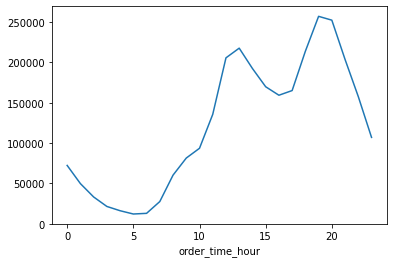

In [72]:
# number of orders by hour
print(df_order.groupby('order_time_hour').count().account_id)
df_order.groupby('order_time_hour').count().account_id.plot(kind='line')

In [81]:
# number of available vendors by hours
df_order.groupby(['order_time_hour']).vendor_id.nunique()

order_time_hour
0     3341
1     2709
2     2103
3     1492
4     1132
5     1058
6     1041
7     1562
8     2440
9     3032
10    4097
11    5689
12    6689
13    6844
14    6814
15    6670
16    6548
17    6532
18    6808
19    6948
20    6927
21    6786
22    6192
23    5073
Name: vendor_id, dtype: int64

In [85]:
available_vendors_list_by_hour = df_order.groupby(['order_time_hour']).vendor_id.unique()

In [60]:
# df_customerlocs = df_order[['account_id','customer_lon','customer_lat']]
# df_customerlocs.drop_duplicates(inplace=True)
# print(df_customerlocs.shape[0])
# df_customerlocs.head()

In [87]:
df_vendor = pd.read_csv('./data/all_vendor_oct_processed.csv',header=0)
df_vendor['vendor_index'] = df_vendor.index
print(df_vendor.shape[0])
df_vendor.head()

8105


,vertical,vendor_id,main_cuisine,vendor_name,vendor_lon,vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


# Retrieve OSM driving road network of Dubai by bouding box
only need to run download code once, can load the saved network data in the future

In [3]:
# %%time
# ## Wall time: 5min
# from pandana.loaders import osm
# network = osm.pdna_network_from_bbox(24.849396, 54.928797, 25.474479, 55.773907, network_type='drive')

In [10]:
# network.nodes_df.to_csv('./output/nodes.csv')
# network.edges_df.to_csv('./output/edges.csv')
# network.edges_df.head()

from          to   distance
21133789 95063474    21133789  95063474   264.64985 
         642942771   21133789  642942771  95.63152  
21162710 267369795   21162710  267369795  679.96710 
         1014768766  21162710  1014768766 1180.95844
21162918 1014766460  21162918  1014766460 1221.37087

In [8]:
%%time
# load existing network data
nodes = pd.read_csv('./output/nodes.csv', index_col=0)
print(nodes.shape[0])
edges = pd.read_csv('./output/edges.csv', index_col=[0,1])
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

110123
CPU times: user 50.8 s, sys: 1.5 s, total: 52.3 s
Wall time: 3.25 s


# Assign nearest network node_ids to each customer location

In [12]:
%%time
all_nodes = network.get_node_ids(df_order.customer_lon, df_order.customer_lat).values
print(all_nodes.shape[0]) #2919915
df_order['node_id'] = all_nodes
print(df_order.node_id.unique().shape[0])  #87601

2919915
41921
CPU times: user 3.14 s, sys: 20.4 ms, total: 3.16 s
Wall time: 3.16 s


In [35]:
# %%time
# customer_nodes = network.get_node_ids(df_customerlocs.customer_lon, df_customerlocs.customer_lat).values
# print(customer_nodes.shape[0])
# df_customerlocs['node_id'] = customer_nodes
# df_customerlocs.node_id.unique().shape[0]

# Identify nearest restaurants
https://github.com/UDST/pandana/blob/dev/examples/Pandana-demo.ipynb

In [90]:
df_vendor = df_vendor.rename(columns={"vendor_id": "n_vendor_id","main_cuisine":"n_main_cuisine",'vendor_name':'n_vendor_name',
                                       'vendor_lon':'n_vendor_lon','vendor_lat':'n_vendor_lat','vertical':'n_vertical'})
print(df_vendor.shape[0])
print(df_vendor.n_main_cuisine.unique().shape[0])
df_vendor.head()

8105
66


,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


In [1]:
%%time

max_search_resturants = 1 
max_dist = 50000 # 50km 
output_file = './data/Dubai_all_delivery_202310_processed_nearest_new.csv'

# loop hour, for each hour we construct different network with different available restaurants
for hour in range(0,24):
    df_order_byhour = df_order[df_order['order_time_hour']==hour]
    print(datetime.datetime.now(),'Hour:',hour,', total orders in this hour:',df_order_byhour.shape[0])
    df_vendor_byhour = df_vendor[df_vendor['n_vendor_id'].isin(available_vendors_list_by_hour[hour])]
    print(' Number of available restaurants:',len(available_vendors_list_by_hour[hour]),df_vendor_byhour.n_vendor_id.unique().shape[0])
    
    # Step 1. Add different types of restaurants into the network. We assume these are the available restaurants to people.
    network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])
    for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
        df_vendor_onetype = df_vendor_byhour[df_vendor_byhour['n_main_cuisine']==cat]
        network.set_pois(category = cat,
                         maxdist = max_dist,
                         maxitems = max_search_resturants, # max number of restaurants to search
                         x_col = df_vendor_onetype.n_vendor_lon, 
                         y_col = df_vendor_onetype.n_vendor_lat)
    
    
    # Step 2. Search the nearest same type of restaurants
    i = 1
    for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
        try:
            print(datetime.datetime.now(), cat, i,'/',df_vendor_byhour.n_main_cuisine.unique().shape[0])
            i+=1
            # return the nearest restaurants offering the same cuisine
            df_nearest_samerest = network.nearest_pois(distance = max_dist,
                                       category = cat,
                                       num_pois = max_search_resturants,
                                       include_poi_ids = True)
            df_nearest_samerest = df_nearest_samerest.reset_index()
            df_nearest_samerest.dropna(inplace=True) # drop nodes without any nearest restaurants within max_dist
            df_nearest_samerest.poi1 = df_nearest_samerest.poi1.astype(int)
            df_nearest_samerest = df_nearest_samerest.rename(columns={"id": "node_id", 1:"nearest_dist1"})# nearest_dist1: this is the distance to the nearest restaurant
            #,"poi1":"vendor_index"

            # left join the identified nearest restaurant with the order data, make sure controling the same cuisine types
            df_order_onetype = df_order_byhour[df_order_byhour['main_cuisine']==cat] 
            df_order_onetype_mergedist = df_order_onetype.merge(df_nearest_samerest, on='node_id')
            df_order_onetype_mergedist = df_order_onetype_mergedist.merge(df_vendor_byhour,left_on='poi1',right_on='vendor_index')

            if not os.path.isfile(output_file):
                df_order_onetype_mergedist.to_csv(output_file,index=False)
            else: # else it exists so append without writing the header
                df_order_onetype_mergedist.to_csv(output_file, mode='a', header=False,index=False)

        except Exception:
            traceback.print_exc()
            print(cat)    

# Compute shortest path (network distance) between customer and restaurants actually ordering from

In [2]:
%%time
output_file = './data/Dubai_all_delivery_202310_processed_nearest_new.csv'
df_localness = pd.read_csv(output_file, sep=",", header=0)
print(df_localness.shape[0])
df_localness.head(2)

2916590
CPU times: user 13.7 s, sys: 2.23 s, total: 16 s
Wall time: 22.2 s


In [5]:
%%time
df_localness['nearest_dist1'] = df_localness['nearest_dist1']/1000  # convert to km

# first, identify the nearest node to each lon lat coordinate
customer_nodes = network.get_node_ids(df_localness.customer_lon, df_localness.customer_lat).values
vendor_nodes = network.get_node_ids(df_localness.vendor_lon, df_localness.vendor_lat).values

# second, compute the shortest network distance for each pair of nodes
distances_order = network.shortest_path_lengths(vendor_nodes, customer_nodes)
print(len(distances_order))
# pandana_distance_realdist: this is the real network distance between customer and the vendor
df_localness['pandana_distance_realdist'] = [x / 1000 for x in distances_order] # convert to km

NameError: name 'network' is not defined

In [23]:
# %%time
# n_vendor_nodes = G.get_node_ids(df_order.n_vendor_lon, df_order.n_vendor_lat).values
# distances_to_nearest_restaurants = G.shortest_path_lengths(n_vendor_nodes, customer_nodes)
# df_localness['pandana_distance_nearest_dist'] = [x / 1000 for x in distances_to_nearest_restaurants] 

# Compute localness index

In [10]:
# %%time
# df_localness = pd.read_csv('./data/food_localness_oct.csv',header=0)

CPU times: user 18.2 s, sys: 896 ms, total: 19.1 s
Wall time: 1min 13s


In [9]:
df_localness['pandana_localness'] = df_localness['nearest_dist1']/df_localness['pandana_distance_realdist']

In [ ]:
# exclude some extreme or abnormal orders based on distance and speed
df_localness = df_localness[df_localness['pandana_distance_realdist']<50] # order distance must be less than 50km
df_localness['speed'] = df_localness['pandana_distance_realdist']/(df_localness['delivery_duration']/60) # order travel speed, km/h
df_localness = df_localness[df_localness['speed']<60] #must be < 60km/h

# around 5% of the orders are from the nearest restaurants: 
print(df_localness[df_localness['pandana_localness']>=1].shape[0])
print(df_localness[df_localness['pandana_localness']>=1].shape[0]/df_localness.shape[0])

In [1]:
df_localness.to_csv('./data/food_localness_oct.csv',sep=',',index=False)

# (Optional) Localness index exploration

In [19]:
# before excluding abnormal values
# print(df_localness.shape[0])
# df_localness.pandana_distance_realdist.describe()
# df_localness.delivery_duration.describe()
# df_localness.total_duration.describe()

# After exclude abnormal values: 2.8 million orders
print(df_localness.shape[0])
df_localness.pandana_distance_realdist.describe()

2824594


count   2824594.00000
mean    5.64253      
std     4.04874      
min     0.00000      
25%     2.47330      
50%     4.74912      
75%     7.99198      
max     46.27318     
Name: pandana_distance_realdist, dtype: float64

In [130]:
df_localness.groupby('main_cuisine').pandana_localness.mean().sort_values(ascending=False)

main_cuisine
specialty store   1.00000
peruvian          1.00000
kuwaiti           1.00000
iraqi             1.00000
spanish           1.00000
latin american    1.00000
french            0.99952
mongolian         0.99422
singaporean       0.98810
tunisian          0.97917
sliders           0.94545
portuguese        0.92505
argentinian       0.92091
syrian            0.89866
saudi             0.89578
british           0.89450
brazilian         0.88923
gluten free       0.88877
georgian          0.88396
indonesian        0.86975
nepalese          0.84101
vietnamese        0.82927
european          0.82430
mediterranean     0.82418
middle eastern    0.81357
jordanian         0.78924
soup              0.77629
korean            0.76819
greek             0.74556
bowls             0.73142
moroccan          0.72221
uzbek             0.69631
afghani           0.69397
vegetarian        0.68598
russian           0.67443
palestinian       0.67259
keto              0.67237
chicken           0.65618

In [22]:
# df_localness['pandana_localness'].hist(bins=40,ec='None')